In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=efa21f828d765a9de35b5be7be0c79a0a9d811f2b034b1592a49bce281defdbe
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [3]:
cd '/content/drive/MyDrive/BloodCellClassification'

/content/drive/MyDrive/BloodCellClassification


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from utils.models import cnn, dilated_cnn, resnet, vgg, autoencoder, autoclassifier
from utils.training import train_cnn, train_autoencoder
from medmnist import BloodMNIST

In [5]:
# Define a function to get the label names
def label_name(label):
    names = ['Eosinophil', 'Basophil', 'Neutrophil', 'Lymphocyte', 'Monocyte', 'Platelet', 'RBC', 'Background']
    return names[label]

In [6]:
# Load the dataset of the images using size 64
train_dataset = BloodMNIST(split='train', download=True, size=64)
val_dataset = BloodMNIST(split='val', download=True, size=64)
test_dataset = BloodMNIST(split='test', download=True, size=64)

# Extract images only (assuming train_dataset.data contains images and labels)
# Normalize images to [0, 1] range if not already normalized
def preprocess_dataset(dataset):
    # Adjust this based on dataset structure
    try:
        images = dataset.images  # Use correct attribute if available
    except AttributeError:
        images = [dataset[i][0] for i in range(len(dataset))]  # Extract images manually

    # Normalize images to [0, 1]
    images = np.array(images) / 255.0  # Convert to NumPy if not already
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Create (input, target) pairs
    dataset = tf.data.Dataset.from_tensor_slices((images, images))
    return dataset

# Preprocess datasets
train_autoencoder_dataset = preprocess_dataset(train_dataset)
val_autoencoder_dataset = preprocess_dataset(val_dataset)
test_autoencoder_dataset = preprocess_dataset(test_dataset)

# Batch the datasets
batch_size = 64  # Define your batch size
train_autoencoder_dataset = train_autoencoder_dataset.batch(batch_size, drop_remainder=True)
val_autoencoder_dataset = val_autoencoder_dataset.batch(batch_size, drop_remainder=True)
test_autoencoder_dataset = test_autoencoder_dataset.batch(batch_size, drop_remainder=True)

100%|██████████| 156M/156M [00:01<00:00, 126MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


In [7]:

# Convert the datasets into tf.data.Dataset format
def create_tf_dataset(medmnist_dataset):
    images = []
    labels = []

    # Collect images and labels
    for img, label in medmnist_dataset:
        images.append(img)
        labels.append(label)

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Create TensorFlow dataset
    return tf.data.Dataset.from_tensor_slices((images, labels))

In [8]:
# Convert MedMNIST datasets to TensorFlow datasets
train_tf_dataset = create_tf_dataset(train_dataset)
val_tf_dataset = create_tf_dataset(val_dataset)
test_tf_dataset = create_tf_dataset(test_dataset)

In [9]:
# Function to preprocess the images (convert to Tensor and normalize)
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] like PyTorch's ToTensor
    return image, label

In [10]:
# Apply preprocessing to the datasets
train_tf_dataset = train_tf_dataset.map(preprocess_image)
val_tf_dataset = val_tf_dataset.map(preprocess_image)
test_tf_dataset = test_tf_dataset.map(preprocess_image)

# Batch the datasets (like PyTorch's DataLoader)
batch_size = 64
train_tf_dataset = train_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_tf_dataset = val_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_tf_dataset = test_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

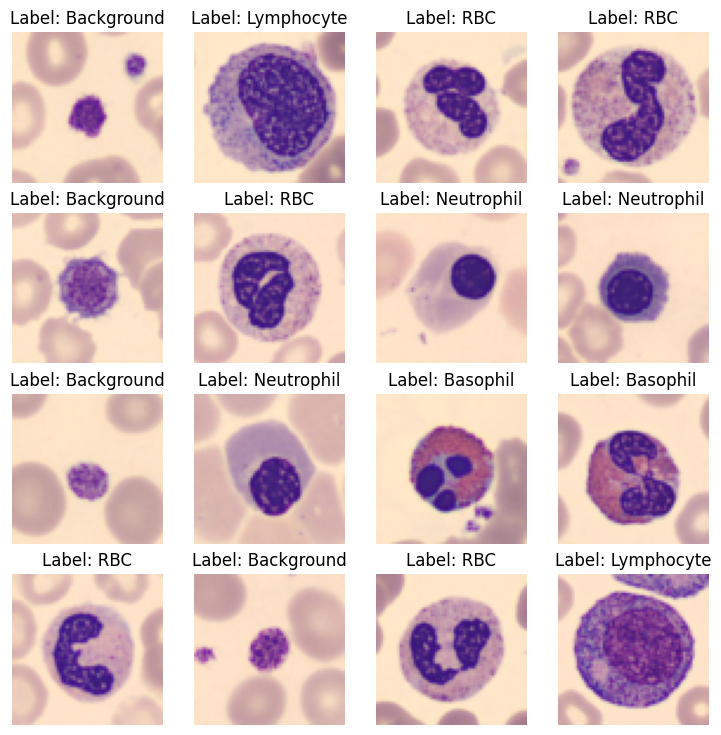

In [11]:
# Visualize a batch of training data
for images, labels in train_tf_dataset.take(1):
    # Plot images (display first 16 images in the batch)
    plt.figure(figsize=(9, 9))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy())  # Convert tensor to numpy for plotting
        plt.title(f"Label: {label_name(labels[i].numpy()[0])}")
        plt.axis('off')
    plt.show()

## Data Balance
Note for myself, I only did this for the training set, I would have to to it for the validation and test sets as well.

In [ ]:
# Extract all the labels from the dataset
all_labels_train = []
all_labels_val = []
all_labels_test = []

for _, label in train_dataset:
  label_number = tuple(label)[0]
  all_labels_train.append(label_name(label_number))

for _, label in val_dataset:
  label_number = tuple(label)[0]
  all_labels_val.append(label_name(label_number))
for _, label in test_dataset:
  label_number = tuple(label)[0]
  all_labels_test.append(label_name(label_number))

# Count instances per class
class_counts = Counter(all_labels_train)
print("Class Counts train dataset:", class_counts)

class_counts = Counter(all_labels_val)
print("Class Counts validation dataset:", class_counts)

class_counts = Counter(all_labels_test)
print("Class Counts test dataset:", class_counts)

# Calculate proportions
classes, counts = zip(*sorted(class_counts.items()))
total_samples = sum(counts)
class_proportions = {cls: count / total_samples for cls, count in class_counts.items()}
print("Class Proportions:", class_proportions)

# Class ratio
largest_class = max(counts)
smallest_class = min(counts)
class_ratio = largest_class / smallest_class
print(f"Class Ratio (Largest:Smallest) = {class_ratio:.2f}")

Class Counts train dataset: Counter({'RBC': 2330, 'Basophil': 2181, 'Lymphocyte': 2026, 'Background': 1643, 'Neutrophil': 1085, 'Platelet': 993, 'Eosinophil': 852, 'Monocyte': 849})
Class Counts val dataset: Counter({'RBC': 333, 'Basophil': 312, 'Lymphocyte': 290, 'Background': 235, 'Neutrophil': 155, 'Platelet': 143, 'Monocyte': 122, 'Eosinophil': 122})
Class Counts test dataset: Counter({'RBC': 666, 'Basophil': 624, 'Lymphocyte': 579, 'Background': 470, 'Neutrophil': 311, 'Platelet': 284, 'Eosinophil': 244, 'Monocyte': 243})
Class Proportions: {'Lymphocyte': 0.16924875767319497, 'Eosinophil': 0.07132417421806489, 'Basophil': 0.1824028061970184, 'RBC': 0.19467991815258695, 'Platelet': 0.08301666179479684, 'Neutrophil': 0.09090909090909091, 'Monocyte': 0.0710318620286466, 'Background': 0.1373867290266004}
Class Ratio (Largest:Smallest) = 2.74


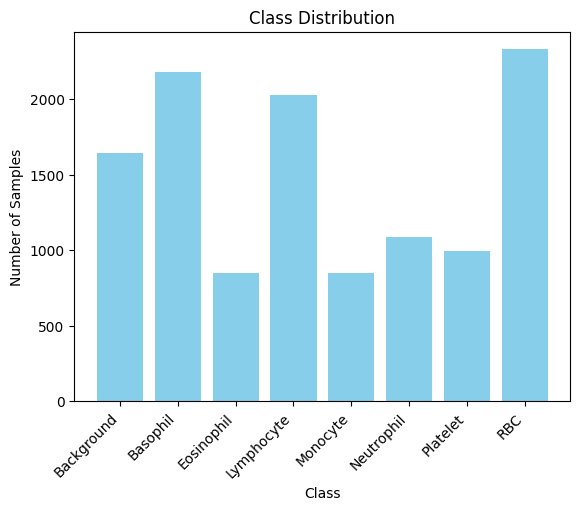

In [ ]:
# Visualize the distribution of labels
plt.bar(classes, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

## CNN

In [13]:
# Define input shape
input_shape = (64, 64, 3)

# Create the CNN model
model = cnn(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │     268,435,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,891,976 (1.00 GB)

 Trainable params: 268,891,976 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 290ms/step - accuracy: 0.4538 - loss: 2.4210 - val_accuracy: 0.8236 - val_loss: 0.4875
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.8194 - loss: 0.4884 - val_accuracy: 0.8989 - val_loss: 0.2933
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.8880 - loss: 0.3168 - val_accuracy: 0.9176 - val_loss: 0.2530
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.9038 - loss: 0.2641 - val_accuracy: 0.9252 - val_loss: 0.2227
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.9280 - loss: 0.2093 - val_accuracy: 0.9398 - val_loss: 0.1833
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.9427 - loss: 0.1645 - val_accuracy: 0.9486 - val_loss: 0.1747
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.9461 - loss: 0.1486 - val_accuracy: 0.9311 - val_loss: 0.2214
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.9471 - loss: 0

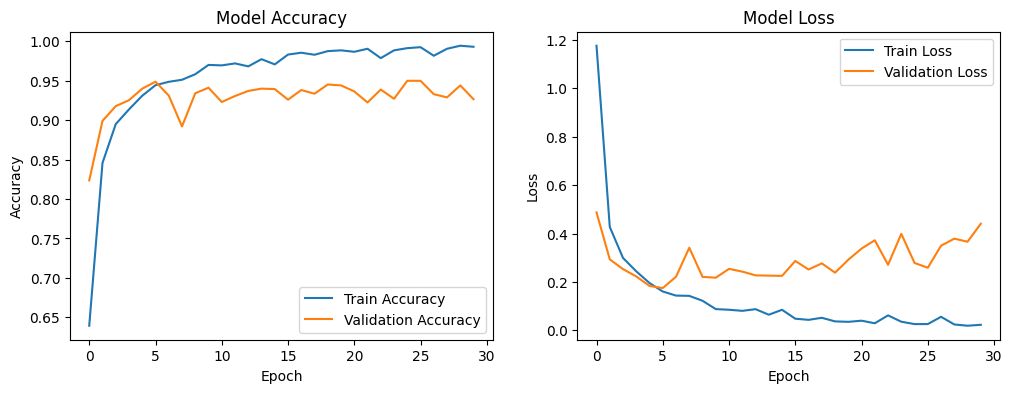

In [14]:
# Train model
trained_model, history = train_cnn(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=30,
    learning_rate=0.001
)

## Dilated CNN

In [15]:
# Define input shape
input_shape = (64, 64, 3)

# Create the Dilated CNN model
model = dilated_cnn(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "dilated_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │     268,435,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,891,976 (1.00 GB)

 Trainable params: 268,891,976 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 304ms/step - accuracy: 0.4635 - loss: 2.5320 - val_accuracy: 0.8049 - val_loss: 0.5247
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.8101 - loss: 0.5121 - val_accuracy: 0.8791 - val_loss: 0.3143
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 225ms/step - accuracy: 0.8646 - loss: 0.3637 - val_accuracy: 0.9060 - val_loss: 0.2546
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 228ms/step - accuracy: 0.8864 - loss: 0.3126 - val_accuracy: 0.9159 - val_loss: 0.2336
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.9054 - loss: 0.2571 - val_accuracy: 0.9106 - val_loss: 0.2497
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 228ms/step - accuracy: 0.9232 - loss: 0.2143 - val_accuracy: 0.9410 - val_loss: 0.1752
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.9331 - loss: 0.1845 - val_accuracy: 0.9176 - val_loss: 0.2497
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 224ms/step - accuracy: 0.9376 - loss: 0

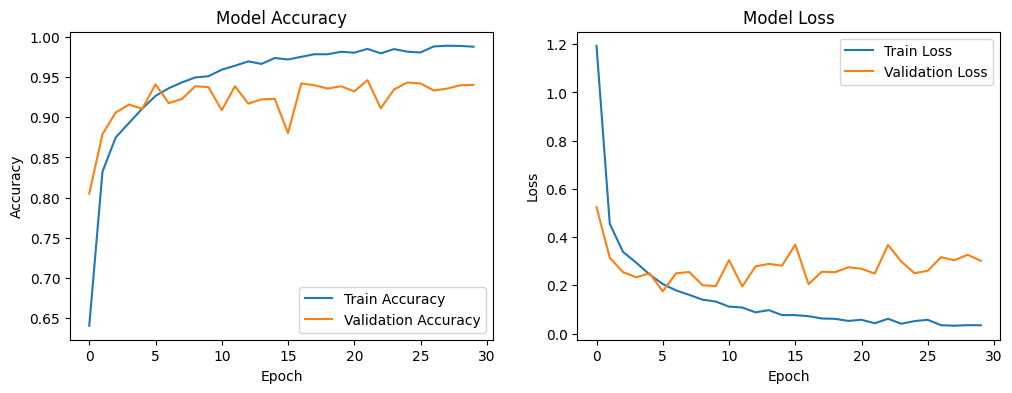

In [16]:
# Train model
trained_model, history = train_cnn(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=30,
    learning_rate=0.001
)

## ResNet

In [12]:
# Define input shape
input_shape = (64, 64, 3)

# Create the ResNet model
model = resnet(input_shape=input_shape)

# Print the model summary
model.summary()

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'layers'

In [ ]:
# Train model
trained_model, history = train_cnn(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=30,
    learning_rate=0.001
)

## VGG

In [17]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │     268,435,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,675,816 (1.00 GB)

 Trainable params: 269,675,816 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train model
trained_model, history = train_cnn(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=30,
    learning_rate=0.001
)

Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-18-fa25dbbc1dfb>", line 2, in <cell line: 2>

  File "/content/drive/MyDrive/BloodCellClassification/utils/training.py", line 30, in train_cnn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 3061366360 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_174115]

## Autoencoder

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the autoencoder model
encoder, decoder, model = autoencoder(input_shape=input_shape)

# Print the model summary
encoder.summary()
decoder.summary()
model.summary()

In [ ]:
# Train the autoencoder
trained_model, history = train_autoencoder(
    model=model,
    train_dataset=train_autoencoder_dataset,
    val_dataset=val_autoencoder_dataset,
    epochs=30,
    learning_rate=0.001
)

In [ ]:
# Detach the decoder and add a CNN-like architecture
model = autoclassifier(encoder)

# Print the model summary
model.summary()

In [ ]:
# Train the resulting classifier
trained_model, history = train_cnn(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=30,
    learning_rate=0.001
)

## Feature extraction (work in progress)



In [ ]:
def make_gradcam_heatmap(model, image, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    # and the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Forward pass through the model and compute the gradients of the target class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the class channel with respect to the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Calculate the mean intensity of the gradients across each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with respect to the target class
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Specify the last convolutional layer in your model
last_conv_layer_name = "conv2d_7"

input_image, _ = train_dataset[0]
input_image = tf.keras.utils.img_to_array(input_image) # Convert PIL Image to numpy array
input_image = tf.expand_dims(input_image, axis=0)

# Generate the heatmap
heatmap = make_gradcam_heatmap(model, input_image, last_conv_layer_name)


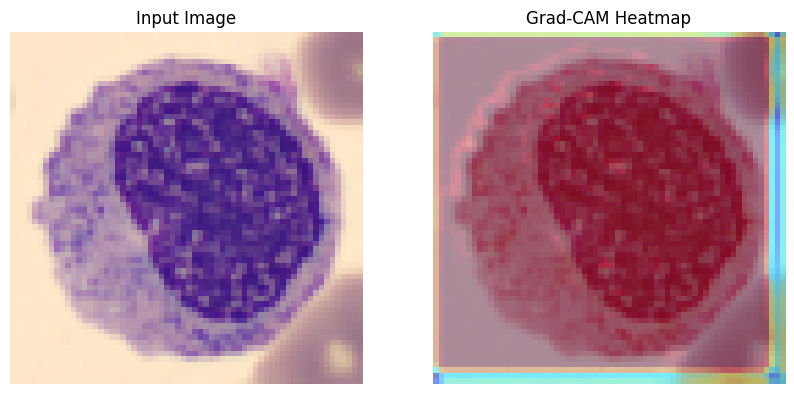

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load your pre-trained model
input_shape = (64, 64, 3)  # Adjust this to your input image shape
model = cnn(input_shape)

# Preprocess the input image and get the model's prediction
input_image, _ = train_dataset[1]  # Assuming train_dataset is already defined
input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
predictions = model(input_image)
predicted_class = tf.argmax(predictions[0])

# Define the Grad-CAM function
def grad_cam(model, image, target_class):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.layers[4].output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, target_class]

    # Compute gradients of the target class with respect to the conv layer
    grads = tape.gradient(loss, conv_outputs)

    # Compute the channel-wise mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the conv layer by the importance of that channel
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to the heatmap (only positive gradients)
    heatmap = tf.maximum(heatmap, 0)
    max_heat = tf.reduce_max(heatmap)
    if max_heat > 0:
        heatmap /= max_heat  # Normalize between 0 and 1

    return heatmap.numpy()

# Generate the Grad-CAM heatmap
heatmap = grad_cam(model, input_image, target_class=predicted_class)

# Resize heatmap to match input image size
heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[1]))
heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255] range

# Apply the heatmap on the image
heatmap_img = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(input_image[0].numpy(), cv2.COLOR_RGB2BGR), 0.6, heatmap_img, 0.4, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


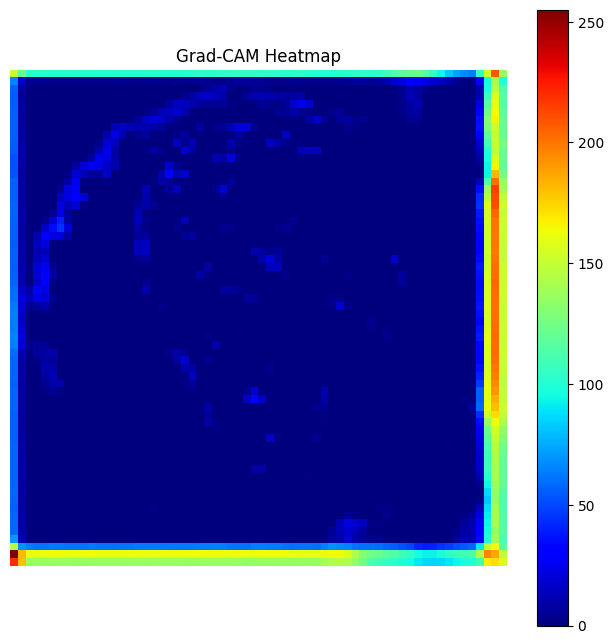

In [ ]:
input_image,_ = test_dataset[0]
# Generate the Grad-CAM heatmap
input_image, _ = test_dataset[2]
input_image = tf.keras.utils.img_to_array(input_image) # Convert PIL Image to numpy array
input_image = tf.expand_dims(input_image, axis=0)

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[1]))
heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255] range for visualization

# Plot only the heatmap
plt.figure(figsize=(8, 8))
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')  # Use a colormap to visualize intensity
plt.axis('off')
plt.colorbar()  # Optional: add a color bar to show scale

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted: [[-25.47567   -16.498798    8.626999   33.075848  -10.512786   -5.7605243
   23.374407  -15.637039   39.760105  -25.907785 ]]


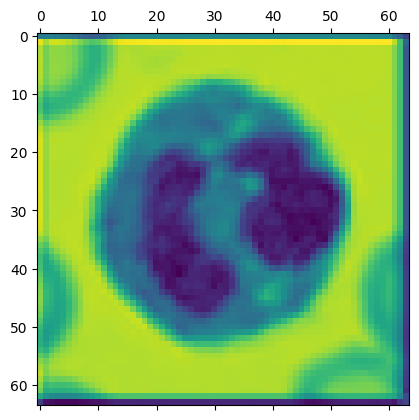

In [ ]:
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_array,_=test_dataset[2]
# Convert PIL Image to numpy array
img_array = tf.keras.utils.img_to_array(img_array)

# Add batch dimension
img_array = tf.expand_dims(img_array, axis=0)

model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# last_conv_layer_name = "max_pooling2d_39"
last_conv_layer_name = "conv2d_39"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

(-0.5, 63.5, 63.5, -0.5)

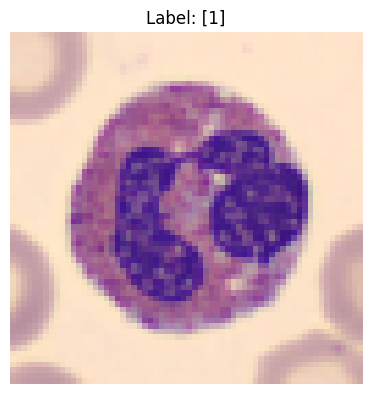

In [ ]:
input_image, label = test_dataset[2]

# Display the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image)
plt.title(f"Label: {label}")
plt.axis('off')